In [1]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from load_train_data import overview_data
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import l1_min_c

from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [2]:
x_train_df = pd.read_csv('x_train.csv')
y_train_df = pd.read_csv('y_train.csv')

overview_data(x_train_df, y_train_df)

x_train_df['total_text'] = x_train_df['website_name'] + ' ' + x_train_df['text']
x_train_df_text = x_train_df['website_name'] + ' ' + x_train_df['text']
x_train_df_text.head()


Shape of x_train_df: (2400, 2)
Shape of y_train_df: (2400, 1)

Print three instance from the training set in lists:
Input (website, review):
[['amazon', 'Oh and I forgot to also mention the weird color effect it has on your phone.'], ['amazon', "THAT one didn't work either."], ['amazon', 'Waste of 13 bucks.']]
Label:
[0, 0, 0]


More data from training set:
row     0 | y = 0 | Oh and I forgot to also mention the weird color effect it has on your phone.
row     1 | y = 0 | THAT one didn't work either.
row     2 | y = 0 | Waste of 13 bucks.
row     3 | y = 0 | Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.
row     4 | y = 0 | None of the three sizes they sent with the headset would stay in my ears.
...
row  2395 | y = 1 | The sweet potato fries were very nice and seasoned well.
row  2396 | y = 1 | I could eat their bruschetta all day it is devine.
row  2397 | y = 1 | Ambience is perfect.
row  2398 | y = 1 | We 

0    amazon Oh and I forgot to also mention the wei...
1                  amazon THAT one didn't work either.
2                            amazon Waste of 13 bucks.
3    amazon Product is useless, since it does not h...
4    amazon None of the three sizes they sent with ...
dtype: object

In [4]:
# X_train, X_heldout, y_train, y_heldout = train_test_split(x_train_df_text, y_train_df['is_positive_sentiment'], train_size=.95, random_state=1234)
X_train = x_train_df_text
y_train = y_train_df['is_positive_sentiment']

In [5]:
import string
    
#vectorizer 1 --> lowercase + stop words
vectorizer_1 = TfidfVectorizer(ngram_range=(1,1), lowercase=True, stop_words='english')
vectorizer_1.fit(X_train)
X_train_vector_1 = vectorizer_1.transform(X_train)
vocabulary_size_1 = len(vectorizer_1.vocabulary_)  # retrieve vocabulary and measure its size
print(vocabulary_size_1)

#vectorizer 2 --> lowercase + stop words + words that appear less than 2 times are eliminated
vectorizer_2 = TfidfVectorizer(ngram_range=(1,1), lowercase=True, stop_words='english', min_df=2)
vectorizer_2.fit(X_train)
X_train_vector_2 = vectorizer_2.transform(X_train)
vocabulary_size_2 = len(vectorizer_2.vocabulary_)  # retrieve vocabulary and measure its size
print(vocabulary_size_2)

#vectorizer 3 --> lowercase + stop words + words that appear less than 3 times are eliminated
vectorizer_3 = TfidfVectorizer(ngram_range=(1,1), lowercase=True, stop_words='english', min_df=3)
vectorizer_3.fit(X_train)
X_train_vector_3 = vectorizer_3.transform(X_train)
vocabulary_size_3 = len(vectorizer_3.vocabulary_)  # retrieve vocabulary and measure its size
print(vocabulary_size_3)

4256
1687
1005


In [8]:
simple_randomforest = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, stop_words='english', min_df = 2, ngram_range=(1, 1))),
    ('forest', RandomForestClassifier())
])

In [9]:
param_grid = {
    'forest__max_depth': [5, 25, 50, 150, 300, 500],  # Maximum depth of trees
}

print('Created the grid!')  


Created the grid!


In [10]:
from sklearn.metrics import roc_auc_score, make_scorer

scoring = make_scorer(roc_auc_score, greater_is_better=True)

grid_forest_5 = GridSearchCV(simple_randomforest, param_grid, scoring=scoring, cv=5, return_train_score=True)
grid_search_forest = grid_forest_5.fit(X_train, y_train)
print('Done grid search for CV 5!')

Done grid search for CV 5!


In [11]:
best_params = grid_forest_5.best_params_
print(best_params)
print("Best ROC AUC score found:", grid_forest_5.best_score_)



{'forest__max_depth': 150}
Best ROC AUC score found: 0.7575000000000001


In [23]:
cv_results = grid_forest_5.cv_results_

# Extract hyperparameters and scores
params = cv_results['params']
mean_test_scores = cv_results['mean_test_score']
mean_train_scores = cv_results['mean_train_score']
std_test_scores = cv_results['std_test_score']
std_train_scores = cv_results['std_train_score']
split0_test_scores = cv_results['split0_test_score']
split1_test_scores = cv_results['split1_test_score']
split2_test_scores = cv_results['split2_test_score']
split3_test_scores = cv_results['split3_test_score']
split4_test_scores = cv_results['split4_test_score']

split0_train_scores = cv_results['split0_train_score']
split1_train_scores = cv_results['split1_train_score']
split2_train_scores = cv_results['split2_train_score']
split3_train_scores = cv_results['split3_train_score']
split4_train_scores = cv_results['split4_train_score']
print(mean_test_scores)
print(cv_results.keys())

[0.72375    0.73958333 0.74833333 0.7575     0.75208333 0.755     ]
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_forest__max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


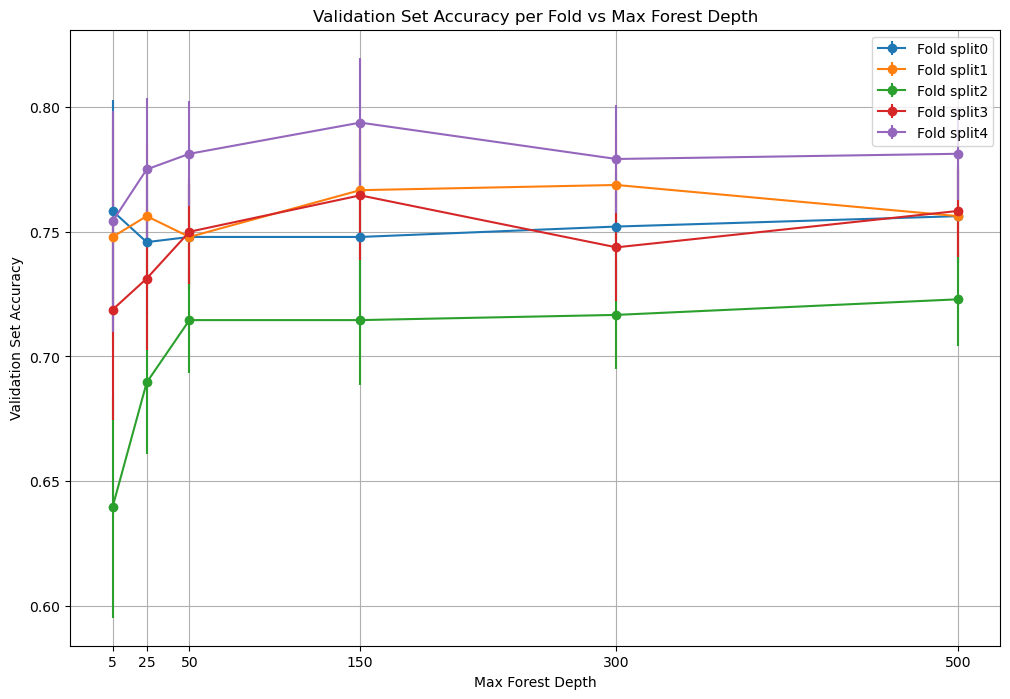

In [24]:
# Extract forest__max_depth values
max_depth_values = [param['forest__max_depth'] for param in params]

# Extract test scores for each fold
split_test_scores = {
    'split0': split0_test_scores,
    'split1': split1_test_scores,
    'split2': split2_test_scores,
    'split3': split3_test_scores,
    'split4': split4_test_scores
}

# Plotting the data
plt.figure(figsize=(12, 8))

for split, scores in split_test_scores.items():
    plt.errorbar(max_depth_values, scores, yerr=std_test_scores, fmt='o-', label=f'Fold {split}')

plt.title('Validation Set Accuracy per Fold vs Max Forest Depth')
plt.xlabel('Max Forest Depth')
plt.ylabel('Validation Set Accuracy')
plt.xticks(max_depth_values) 
plt.grid(True)
plt.legend()
plt.show()

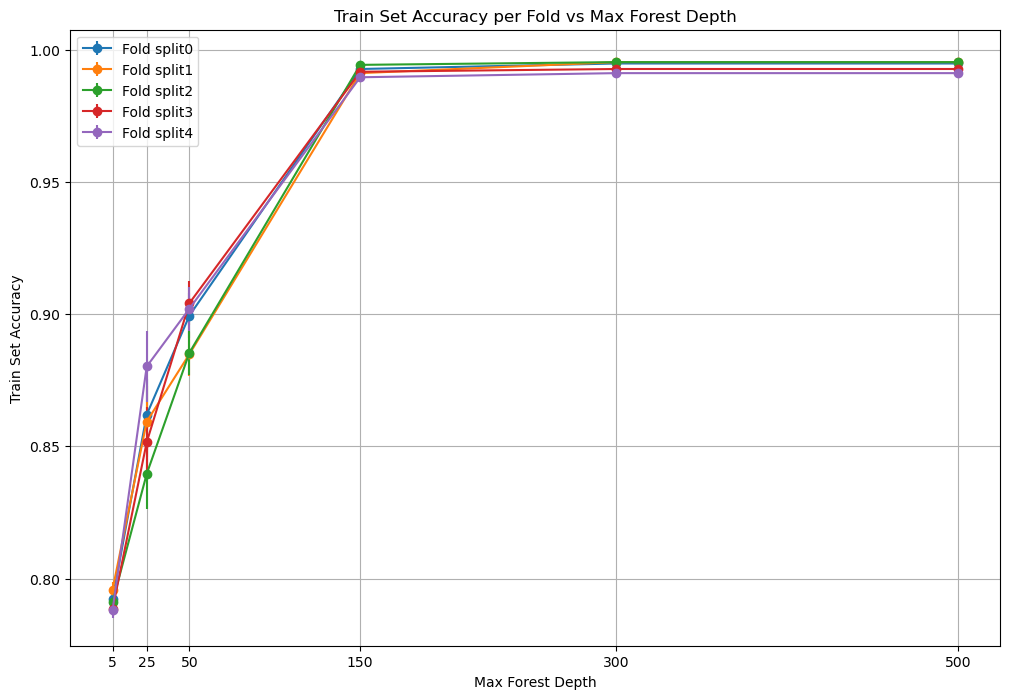

In [25]:
# Extract forest__max_depth values
max_depth_values = [param['forest__max_depth'] for param in params]

# Extract train scores for each fold
split_train_scores = {
    'split0': split0_train_scores,
    'split1': split1_train_scores,
    'split2': split2_train_scores,
    'split3': split3_train_scores,
    'split4': split4_train_scores
}

# Plotting the data
plt.figure(figsize=(12, 8))

for split, scores in split_train_scores.items():
    plt.errorbar(max_depth_values, scores, yerr=std_train_scores, fmt='o-', label=f'Fold {split}')

plt.title('Train Set Accuracy per Fold vs Max Forest Depth')
plt.xlabel('Max Forest Depth')
plt.ylabel('Train Set Accuracy')
plt.xticks(max_depth_values) 
plt.grid(True)
plt.legend()
plt.show()

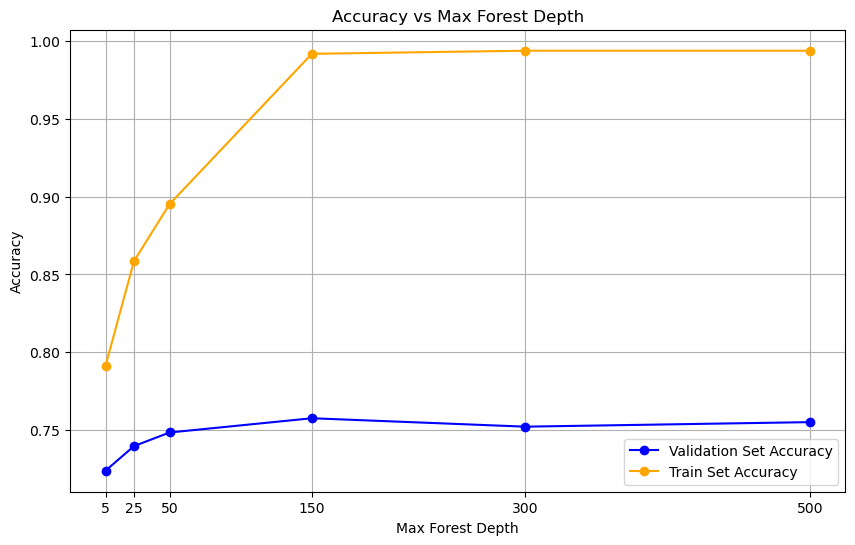

In [29]:
# Extract forest__max_depth values
max_depth_values = [param['forest__max_depth'] for param in params]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, mean_test_scores, marker='o', color='b', label='Validation Set Accuracy')
plt.plot(max_depth_values, cv_results['mean_train_score'], marker='o', color='orange', label='Train Set Accuracy')

plt.title('Accuracy vs Max Forest Depth')
plt.xlabel('Max Forest Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth_values)  # Ensure all depths are shown on x-axis
plt.grid(True)
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold


# Initialize lists to store false negatives and false positives
false_negatives = []
false_positives = []

simple_randomforest = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, stop_words='english', min_df = 2, ngram_range=(1, 1))),
    ('forest', RandomForestClassifier(max_depth=150))
])
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over the first fold only
fold_idx = 0
train_index, val_index = next(stratified_kfold.split(X_train, y_train))
x_train_fold, x_val_fold = x_train_df_text.iloc[train_index], X_train.iloc[val_index]
y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

# Fit the model on the training data for the current fold
simple_randomforest.fit(x_train_fold, y_train_fold)

# Obtain predictions for the validation set in the current fold
fold_predictions = simple_randomforest.predict(x_val_fold)

# Obtain the confusion matrix
cm = confusion_matrix(y_val_fold, fold_predictions)
print(cm)

# Extract false negatives and false positives
false_negatives_indices = np.where((y_val_fold == 1) & (fold_predictions == 0))[0]
false_positives_indices = np.where((y_val_fold == 0) & (fold_predictions == 1))[0]

# Get the texts corresponding to false negatives and false positives
false_negatives_texts = x_val_fold.iloc[false_negatives_indices]
false_positives_texts = x_val_fold.iloc[false_positives_indices]

# Print false negatives
print("False Negatives (Fold 1):")
for idx, text in zip(false_negatives_indices, false_negatives_texts):
    print(f"Index: {idx}, Text: {text}")

# Print false positives
print("\nFalse Positives (Fold 1):")
for idx, text in zip(false_positives_indices, false_positives_texts):
    print(f"Index: {idx}, Text: {text}")


[[205  35]
 [ 67 173]]
False Negatives (Fold 1):
Index: 77, Text: amazon The phone loads super!
Index: 78, Text: amazon Worth every penny.
Index: 81, Text: amazon i'm glad i found this product on amazon it is hard to find, it wasn't high priced.
Index: 91, Text: amazon Virgin Wireless rocks and so does this cheap little phone!
Index: 95, Text: amazon Five star Plus, plus.
Index: 98, Text: amazon its a little geeky but i think thats its sex on toast and it rocks and oozes sex right down to its battery embedded sleek stylish leather case.
Index: 100, Text: amazon I got it because it was so small and adorable.
Index: 101, Text: amazon It finds my cell phone right away when I enter the car.
Index: 106, Text: amazon I really like this product over the Motorola because it is allot clearer on the ear piece and the mic.
Index: 113, Text: amazon Small, sleek, impressive looking, practical setup with ample storage in place.
Index: 120, Text: amazon It worked very well.
Index: 123, Text: amazon V